# Business problem

Two major challenges of anime streaming platforms today include:
1. Boosting user engagement and satisfaction
2.Diversifying user interests

This project aims to build a recommender system to address these challenges by offering personalised anime content using historical user rating data and anime metadata from Kaggle's [Anime Recommendation Database 2020](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020).

In doing so, the recommender can align with **user preferences** and recommend a **diverse range of animes**, including lesser-known titles.

For this project, the Cornac library will be used to develop the anime recommender from pre-processing to deployment. For more information on Cornac, please refer to the links below:
* GitHub: https://github.com/PreferredAI/cornac
* Documentation: https://cornac.readthedocs.io/en/latest/

# Import modules

In [ ]:
!pip install --quiet cornac==1.15.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 36.9 MB/s eta 0:00:00


In [ ]:
import gc
import inflect
import cloudpickle
from google.colab import drive

import re
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None);
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split

import cornac
from cornac.models import MostPop, WMF, CTR
from cornac.data import TextModality
from cornac.data.text import BaseTokenizer
from cornac.eval_methods import RatioSplit
from cornac.hyperopt import Discrete, Continuous
from cornac.hyperopt import RandomSearch
from cornac.metrics import FMeasure, Precision, Recall, AUC, NCRR, NDCG

# Settings
SEED = 2023
VERBOSE = True
PALETTE = "ch:.25"
stopwords = stopwords.words('english')
p = inflect.engine()
wnl = WordNetLemmatizer()

# Mount Google Drive
drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/SMU MITB/3rd Term/CS608: Recommender Systems/Projects/2. Group Project 2/'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


# Helper function

In [ ]:
def clean_text(text):

  '''
  Function for text cleaning
  '''

  text = text.lower()                                   # Lowercase
  text = re.sub(r'[^\w\s]', ' ', text)                  # Remove punctuations
  text = re.sub(r'\bnan\b', ' ', text)                  # Remove 'nan'
  words = text.split()                                  # Split the text / Remove extra spaces

  cleaned_text = []
  for word in words:
      if word not in stopwords:                         # Remove stopwords
          if word.isdigit():
              word = p.number_to_words(word)            # Convert digits to words
          cleaned_text.append(wnl.lemmatize(word))      # Lemmatize text

  return cleaned_text

# Load datasets

To build the anime recommender system, the following datasets will be used:
* `rating_complete.csv` — historical user rating data that includes users who have watched an anime entirely and given a non-zero rating. The columns include the `user_id`, `anime_id` and `rating`.
* `anime.csv` — metadata for each anime in the database.
* `anime_synopsis.csv` — anime metadata with synopsis.

In [ ]:
# Load user ratings data - users that have completely watched the anime and given a non-zero score
ratings = pd.read_csv(filepath + 'Dataset/rating_complete.csv')

# Load anime metadata
anime = pd.read_csv(filepath + 'Dataset/anime.csv')

# Load anime metadata with synopsis
anime_synopsis = pd.read_csv(filepath + 'Dataset/anime_with_synopsis.csv')

# Data exploration / pre-processing

## Ratings

In [ ]:
ratings.head(4)

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7


In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


In [ ]:
# Summary statistics
print("Number of user ratings:", ratings.shape[0])
print('Number of users:', ratings['user_id'].nunique())
print('Number of animes:', ratings['anime_id'].nunique())

print('')

print("Rating count per user:")
print(ratings['user_id'].value_counts().describe())

Number of user ratings: 57633278
Number of users: 310059
Number of animes: 16872

Rating count per user:
count    310059.000000
mean        185.878423
std         255.290522
min           1.000000
25%          43.000000
50%         113.000000
75%         238.000000
max       15455.000000
Name: user_id, dtype: float64


In [ ]:
# Filter for the top 10,000 users with the most number of user ratings
# This helps to reduce the computational resources required to run the whole pipeline
# This also ensures that there's sufficient information to provide meaningful recommendations
user_counts = ratings.groupby('user_id').size().sort_values(ascending = False)
top_users = user_counts.iloc[:10000].index
ratings = ratings[ratings['user_id'].isin(top_users)]

del user_counts, top_users

# Call garbage collection
gc.collect()

4

In [ ]:
# Summary statistics - after filtering
print("Number of user ratings:", ratings.shape[0])
print('Number of users:', ratings['user_id'].nunique())
print('Number of animes:', ratings['anime_id'].nunique())

print('')

print("Rating count per user:")
print(ratings['user_id'].value_counts().describe())

Number of user ratings: 11377077
Number of users: 10000
Number of animes: 16833

Rating count per user:
count    10000.000000
mean      1137.707700
std        639.227359
min        727.000000
25%        816.000000
50%        956.500000
75%       1222.000000
max      15455.000000
Name: user_id, dtype: float64


In [ ]:
# Check for missing values
ratings.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

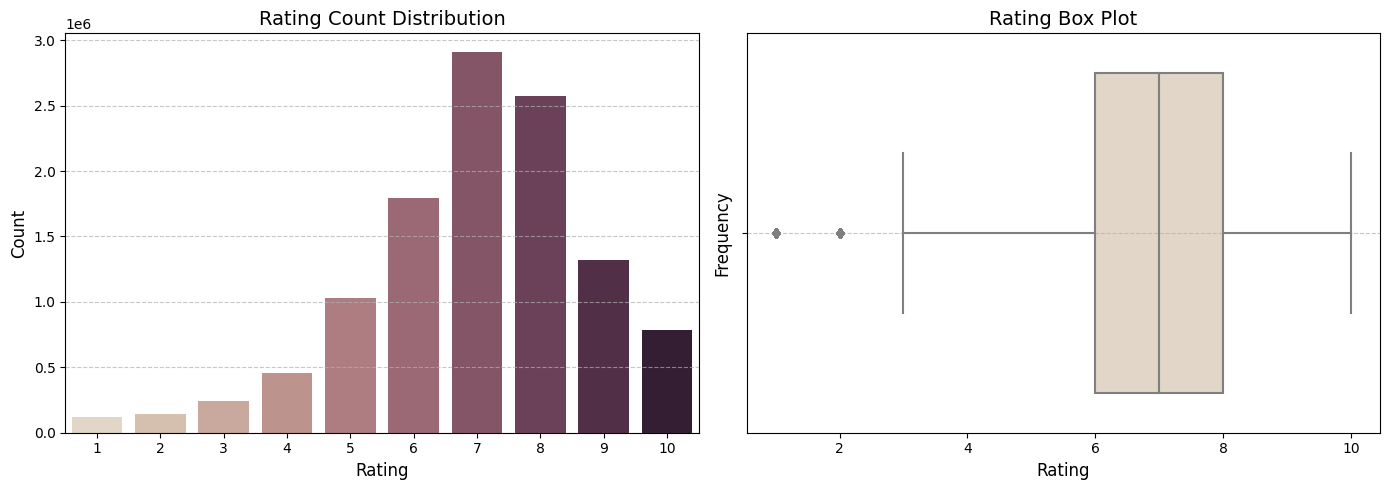

In [ ]:
# Plot the rating distribution
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 5))

sns.countplot(x = "rating", data = ratings, palette = PALETTE, ax = axes[0])
axes[0].set_title('Rating Count Distribution', fontsize = 14)
axes[0].set_xlabel('Rating', fontsize = 12)
axes[0].set_ylabel('Count', fontsize = 12)
axes[0].grid(axis = 'y', linestyle = '--', alpha = 0.7)

sns.boxplot(x = "rating", data = ratings, palette = PALETTE, ax = axes[1])
axes[1].set_title('Rating Box Plot', fontsize = 14)
axes[1].set_xlabel('Rating', fontsize = 12)
axes[1].set_ylabel('Frequency', fontsize = 12)
axes[1].grid(axis = 'y', linestyle = '--', alpha = 0.7)

plt.tight_layout()
plt.show()

Early exploratory analysis shows that user ratings are generally skewed towards the positive end, with a median rating score of **7**. To account for the skewness, a threshold of 7 will be set for the model evaluation phase, where scores below 7 will be deemed negative and scores of 7 and above will be deemed positive.

## Anime

In [ ]:
anime.rename(columns = {'MAL_ID': 'anime_id'}, inplace = True)
anime.columns = map(str.lower, anime.columns)

In [ ]:
anime.head(3)

,anime_id,name,score,genres,english name,japanese name,type,episodes,aired,premiered,producers,licensors,studios,source,duration,rating,ranked,popularity,members,favorites,watching,completed,on-hold,dropped,plan to watch,score-10,score-9,score-8,score-7,score-6,score-5,score-4,score-3,score-2,score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0


In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   anime_id       17562 non-null  int64 
 1   name           17562 non-null  object
 2   score          17562 non-null  object
 3   genres         17562 non-null  object
 4   english name   17562 non-null  object
 5   japanese name  17562 non-null  object
 6   type           17562 non-null  object
 7   episodes       17562 non-null  object
 8   aired          17562 non-null  object
 9   premiered      17562 non-null  object
 10  producers      17562 non-null  object
 11  licensors      17562 non-null  object
 12  studios        17562 non-null  object
 13  source         17562 non-null  object
 14  duration       17562 non-null  object
 15  rating         17562 non-null  object
 16  ranked         17562 non-null  object
 17  popularity     17562 non-null  int64 
 18  members        17562 non-n

In [ ]:
# Check for missing values
anime.isna().sum()

anime_id         0
name             0
score            0
genres           0
english name     0
japanese name    0
type             0
episodes         0
aired            0
premiered        0
producers        0
licensors        0
studios          0
source           0
duration         0
rating           0
ranked           0
popularity       0
members          0
favorites        0
watching         0
completed        0
on-hold          0
dropped          0
plan to watch    0
score-10         0
score-9          0
score-8          0
score-7          0
score-6          0
score-5          0
score-4          0
score-3          0
score-2          0
score-1          0
dtype: int64

## Anime with synopsis

In [ ]:
anime_synopsis.rename(columns = {
    'MAL_ID': 'anime_id',
    'sypnopsis': 'synopsis'},
    inplace = True)
anime_synopsis.columns = map(str.lower, anime_synopsis.columns)

In [ ]:
anime_synopsis.head(4)

,anime_id,name,score,genres,synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...


In [ ]:
anime_synopsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   anime_id  16214 non-null  int64 
 1   name      16214 non-null  object
 2   score     16214 non-null  object
 3   genres    16214 non-null  object
 4   synopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


In [ ]:
# Check for missing values - based on the results, they show that there are some missing synopsis
anime_synopsis.isna().sum()

anime_id    0
name        0
score       0
genres      0
synopsis    8
dtype: int64

# Experiment preparation

_Preparing the datasets to train and evaluate the models in Cornac._

To tackle the business problem of aligning with user preferences and recommending a diverse range of animes, including lesser-known titles (i.e., cold-start items), [Collaborative Topic Regression (CTR)](https://cornac.readthedocs.io/en/latest/models.html#module-cornac.models.ctr.recom_ctr) will be used as it can incorporate user rating and text description data. The text description will be used for content-based filtering to address the issue of cold-start anime titles.

In addition, [Most Popular (MostPop)](https://cornac.readthedocs.io/en/latest/models.html#module-cornac.models.most_pop.recom_most_pop) will be used as the baseline model for recommending popular animes to new users and [Weighted Matrix Factorization (WMF)](https://cornac.readthedocs.io/en/latest/models.html#module-cornac.models.wmf.recom_wmf), which only incorporates the user rating data, will be used for comparison with CTR.

## Text description

In [ ]:
print('Number of animes in ratings dataset:', ratings['anime_id'].nunique())
print('Number of animes in anime dataset:', anime['anime_id'].nunique())
print('Number of animes in anime_synopsis dataset:', anime_synopsis['anime_id'].nunique())

Number of animes in ratings dataset: 16833
Number of animes in anime dataset: 17562
Number of animes in anime_synopsis dataset: 16214


In [ ]:
# Filter the datasets to include only animes IDs in the ratings dataset
ratings_anime_ids = set(ratings['anime_id'])

anime_v2 = anime[anime['anime_id'].isin(ratings_anime_ids)]
anime_v2 = anime_v2.reset_index(drop = True)

anime_synopsis_v2 = anime_synopsis[anime_synopsis['anime_id'].isin(ratings_anime_ids)]
anime_synopsis_v2 = anime_synopsis_v2.reset_index(drop = True)

In [ ]:
# Summary statistics
print('--- OLD ---')
print('Number of animes in previous anime dataset:', anime['anime_id'].nunique())
print('Number of animes in previous anime_synopsis dataset:', anime_synopsis['anime_id'].nunique())

print('')

print('--- NEW ---')
print('Number of animes in new anime dataset:', anime_v2['anime_id'].nunique())
print('Number of animes in new anime_synopsis dataset:', anime_synopsis_v2['anime_id'].nunique())

del ratings_anime_ids, anime, anime_synopsis

# Call garbage collection
print('')
print('Garbage collection:')
gc.collect()

--- OLD ---
Number of animes in previous anime dataset: 17562
Number of animes in previous anime_synopsis dataset: 16214

--- NEW ---
Number of animes in new anime dataset: 16833
Number of animes in new anime_synopsis dataset: 15526

Garbage collection:


35

In [ ]:
# Select the relevant columns from each dataset
anime_v2 = anime_v2[['anime_id', 'name', 'genres', 'type']]
anime_synopsis_v2 = anime_synopsis_v2[['anime_id', 'synopsis']]

# Merge the two datasets
anime_merged = pd.merge(anime_v2, anime_synopsis_v2, on = 'anime_id', how = 'outer')

del anime_v2, anime_synopsis_v2

# Call garbage collection
gc.collect()

0

In [ ]:
anime_merged['name'] = anime_merged['name'].astype('str')
anime_merged['genres'] = anime_merged['genres'].astype('str')
anime_merged['type'] = anime_merged['type'].astype('str')
anime_merged['synopsis'] = anime_merged['synopsis'].astype('str')

# Combine text
anime_merged['combined_text'] = anime_merged['name'] + ' ' + anime_merged['genres'] + ' ' + anime_merged['type'] + ' ' + anime_merged['synopsis']

In [ ]:
# Check for missing values
anime_merged.isna().sum()

anime_id         0
name             0
genres           0
type             0
synopsis         0
combined_text    0
dtype: int64

In [ ]:
anime_merged['combined_text'] = anime_merged['combined_text'].astype('str')

# Clean text
anime_merged['combined_text'] = anime_merged['combined_text'].apply(clean_text)
anime_merged['combined_text'] = anime_merged['combined_text'].apply(lambda x: ' '.join(map(str, x)))

In [ ]:
anime_merged.head(4)

,anime_id,name,genres,type,synopsis,combined_text
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,"In the year 2071, humanity has colonized sever...",cowboy bebop action adventure comedy drama sci...
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",Movie,"other day, another bounty—such is the life of ...",cowboy bebop tengoku tobira action drama myste...
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,"Vash the Stampede is the man with a $$60,000,0...",trigun action sci fi adventure comedy drama sh...
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",TV,ches are individuals with special powers like ...,witch hunter robin action mystery police super...


In [ ]:
anime_merged.drop(columns = ['name', 'genres', 'type', 'synopsis'], inplace = True)

In [ ]:
anime_merged.head(4)

,anime_id,combined_text
0,1,cowboy bebop action adventure comedy drama sci...
1,5,cowboy bebop tengoku tobira action drama myste...
2,6,trigun action sci fi adventure comedy drama sh...
3,7,witch hunter robin action mystery police super...


## Evaluation method / Metrics / Model

In [ ]:
# Instantiate the text modality - to incorporate the text description
item_text_modality = TextModality(
    corpus = anime_merged['combined_text'],
    ids = anime_merged['anime_id'],
    tokenizer = BaseTokenizer(sep = " ", stop_words = "english"),
    max_vocab = 8000,
    max_doc_freq = 0.5
)

In [ ]:
# Convert dataframe to tuples (Cornac's preferred data type)
ratings_data = list(ratings.itertuples(index = False, name = None))

# Define the evaluation method
eval_method = RatioSplit(
    data = ratings_data,
    test_size = 0.2,
    val_size = None,
    rating_threshold = 7.0,   # <<< Set threshold here
    exclude_unknowns = True,
    item_text = item_text_modality,
    verbose = VERBOSE,
    seed = SEED,
)

rating_threshold = 7.0
exclude_unknowns = True
---
Training data:
Number of users = 10000
Number of items = 16818
Number of ratings = 9101661
Max rating = 10.0
Min rating = 1.0
Global mean = 7.0
---
Test data:
Number of users = 10000
Number of items = 16217
Number of ratings = 2275399
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 10000
Total items = 16818


In [ ]:
K_metrics = 50

# Define the evaluation metrics
eval_metrics = [
    AUC(),
    FMeasure(k = K_metrics),
    Precision(k = K_metrics),
    Recall(k = K_metrics),
    NCRR(k = K_metrics),
    NDCG(k = K_metrics)
]

In [ ]:
K_factors = 20

# Instantiate the models
most_pop = MostPop()
wmf = WMF(k = K_factors, max_iter = 10, a = 1.0, b = 0.01, lambda_u = 0.01, lambda_v = 0.01,
          learning_rate = 0.001, name = f"WMF(K={K_factors})", verbose = VERBOSE, seed = SEED)
ctr = CTR(k = K_factors, max_iter = 10, a = 1.0, b = 0.01, lambda_u = 0.01, lambda_v = 0.01,
          name = f"CTR(K={K_factors})", verbose = VERBOSE, seed = SEED)

models = [most_pop, wmf, ctr]

# Run experiment

In [ ]:
cornac.Experiment(eval_method = eval_method, models = models, metrics = eval_metrics).run()

del wmf

# Call garbage collection
gc.collect()


[MostPop] Training started!

[MostPop] Evaluation started!


Ranking:   0%|          | 0/10000 [00:00<?, ?it/s]


[WMF(K=20)] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

[WMF(K=20)] Evaluation started!


Ranking:   0%|          | 0/10000 [00:00<?, ?it/s]


[CTR(K=20)] Training started!


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!

[CTR(K=20)] Evaluation started!


Ranking:   0%|          | 0/10000 [00:00<?, ?it/s]


TEST:
...
          |    AUC |  F1@50 | NCRR@50 | NDCG@50 | Precision@50 | Recall@50 | Train (s) | Test (s)
--------- + ------ + ------ + ------- + ------- + ------------ + --------- + --------- + --------
MostPop   | 0.9254 | 0.0708 |  0.1454 |  0.1399 |       0.1360 |    0.0506 |    0.6941 | 139.7281
WMF(K=20) | 0.7085 | 0.0028 |  0.0049 |  0.0058 |       0.0061 |    0.0019 |   26.4432 | 242.5676
CTR(K=20) | 0.9624 | 0.0792 |  0.1543 |  0.1508 |       0.1473 |    0.0585 |   90.3943 | 248.6292



1996

Based on the evaluation scores, the CTR model performs **better** than the MostPop and WMF models across all the metrics. The results show that adding the text description data helps to improve the model performance. Moving forward, the CTR model will be optimised via hyperparameter tuning.

# Hyperparameter tuning

In [ ]:
# Define parameter grid
param_grid = [
    Discrete('k', [10, 25, 50]),
    Discrete('max_iter', [10, 25, 50]),
    Discrete('a', [0.1, 1.0, 10.0]),
    Discrete('b', [0.1, 1.0, 10.0]),
    Discrete('learning_rate', [0.001, 0.01, 0.1])
]

In [ ]:
# Re-define the evaluation method
eval_method = RatioSplit(
    data = ratings_data,
    test_size = 0.1,
    val_size = 0.1,
    rating_threshold = 7.0,
    exclude_unknowns = True,
    item_text = item_text_modality,
    verbose = VERBOSE,
    seed = SEED,
)

rating_threshold = 7.0
exclude_unknowns = True
---
Training data:
Number of users = 10000
Number of items = 16818
Number of ratings = 9101661
Max rating = 10.0
Min rating = 1.0
Global mean = 7.0
---
Test data:
Number of users = 10000
Number of items = 15478
Number of ratings = 1137701
Number of unknown users = 0
Number of unknown items = 0
---
Validation data:
Number of users = 10000
Number of items = 15534
Number of ratings = 1137698
---
Total users = 10000
Total items = 16818


In [ ]:
# Instantiate Recall@50 for evaluation
rec50 = Recall(k = 50)

# Instantiate RandomSearch
rs_ctr = RandomSearch(
    model = ctr,
    space = param_grid,
    metric = rec50,
    eval_method = eval_method,
    n_trails = 10,
)

In [ ]:
# Run RandomSearch experiment
cornac.Experiment(eval_method = eval_method, models = [rs_ctr], metrics = [rec50]).run()


[RandomSearch_CTR(K=20)] Training started!
Evaluating: {'a': 1.0, 'b': 10.0, 'k': 25, 'learning_rate': 0.001, 'max_iter': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 0.1, 'b': 10.0, 'k': 25, 'learning_rate': 0.001, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 1.0, 'b': 1.0, 'k': 25, 'learning_rate': 0.01, 'max_iter': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 10.0, 'b': 10.0, 'k': 10, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 0.1, 'b': 1.0, 'k': 10, 'learning_rate': 0.1, 'max_iter': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 1.0, 'b': 1.0, 'k': 10, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 1.0, 'b': 0.1, 'k': 25, 'learning_rate': 0.01, 'max_iter': 50}


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 0.1, 'b': 10.0, 'k': 10, 'learning_rate': 0.001, 'max_iter': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 1.0, 'b': 10.0, 'k': 25, 'learning_rate': 0.01, 'max_iter': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!
Evaluating: {'a': 1.0, 'b': 10.0, 'k': 25, 'learning_rate': 0.01, 'max_iter': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Learning completed!
Best parameter settings: {'a': 1.0, 'b': 0.1, 'k': 25, 'learning_rate': 0.01, 'max_iter': 50}
Recall@50 = 0.0686

[RandomSearch_CTR(K=20)] Evaluation started!


Ranking:   0%|          | 0/10000 [00:00<?, ?it/s]

Ranking:   0%|          | 0/10000 [00:00<?, ?it/s]


VALIDATION:
...
                       | Recall@50 | Time (s)
---------------------- + --------- + --------
RandomSearch_CTR(K=20) |    0.0686 |  26.3011

TEST:
...
                       | Recall@50 | Train (s) | Test (s)
---------------------- + --------- + --------- + --------
RandomSearch_CTR(K=20) |    0.0680 | 2545.5884 |  28.6773



In [ ]:
ctr_best_params = rs_ctr.best_params
print('Best parameters: ', ctr_best_params)

Best parameters:  {'a': 1.0, 'b': 0.1, 'k': 25, 'learning_rate': 0.01, 'max_iter': 50}


In [ ]:
# Re-instantiate the CTR model with the best parameters
ctr_optimal = CTR(
    k = ctr_best_params['k'],
    max_iter = ctr_best_params['max_iter'],
    a = ctr_best_params['a'],
    b = ctr_best_params['b'],
    lambda_u = 0.01,
    lambda_v = 0.01,
    name = f"CTR(K={ctr_best_params['k']})",
    verbose = VERBOSE,
    seed = SEED
)

In [ ]:
# Re-define the evaluation method
# This is done to re-train the CTR model on the "entire" dataset
# Since Cornac does not have a fit() function to incoporate the text description data during the model training,
# the test size has been set to a small percentage to train the "entire" dataset with the text description data
eval_method = RatioSplit(
    data = ratings_data,
    test_size = 0.01,
    val_size = None,
    rating_threshold = 7.0,
    exclude_unknowns = True,
    item_text = item_text_modality,
    verbose = VERBOSE,
    seed = SEED,
)

rating_threshold = 7.0
exclude_unknowns = True
---
Training data:
Number of users = 10000
Number of items = 16833
Number of ratings = 11263306
Max rating = 10.0
Min rating = 1.0
Global mean = 7.0
---
Test data:
Number of users = 9999
Number of items = 10935
Number of ratings = 113771
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 10000
Total items = 16833


In [ ]:
# Re-run experiment
cornac.Experiment(eval_method = eval_method, models = [ctr_optimal], metrics = [rec50]).run()

del ratings, ratings_data
del item_text_modality, eval_method, eval_metrics, rec50
del K_metrics, K_factors, models, param_grid
del ctr, rs_ctr, ctr_best_params

# Call garbage collection
gc.collect()


[CTR(K=25)] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CTR(K=25)] Evaluation started!


Ranking:   0%|          | 0/9999 [00:00<?, ?it/s]


TEST:
...
          | Recall@50 | Train (s) | Test (s)
--------- + --------- + --------- + --------
CTR(K=25) |    0.0666 |  589.3944 |  27.4109



40

# Save models

In [ ]:
filepath2 = '/content/drive/MyDrive/Darius stuff/GitHub/GitHub projects/Anime Recommender/'

In [ ]:
# Save MostPop model
most_pop_filepath = filepath2 + 'mostpop.pkl'
with open(most_pop_filepath, 'wb') as f:
  cloudpickle.dump(most_pop, f)

In [ ]:
# Save CTR model
ctr_filepath = filepath2 + 'ctr.pkl'
with open(ctr_filepath, 'wb') as f:
  cloudpickle.dump(ctr_optimal, f)